In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load Cifar10

In [2]:
from tensorflow.python.keras.datasets import cifar10

def loadCifar10():
    (train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
    del train_labels, test_labels
    train_images, test_images = train_images.astype(float), test_images.astype(float)
    train_images /= 255.
    test_images /= 255.
    return train_images, test_images, 128

# Load Birds
From http://www.vision.caltech.edu/visipedia/CUB-200.html dataset

In [3]:
from PIL import Image

def loadBirds(nimages = 12000, w = 128, h = 128):
    
    images = np.zeros((nimages, w, h, 3))
    input_dir = "birds/"
    i = 0
    for dir_ in os.listdir(input_dir):
        idirectory = input_dir + dir_ + "/"
        for path in os.listdir(idirectory):
            if(i < nimages):
                try:
                    images[i] += np.array(Image.open(idirectory + path).resize((w, h)))
                    i += 1
                except:
                    pass
            else:
                break

    images = images[:i]
    images /= 255.
    train_images, test_images = images[:int(0.9 * len(images))], images[int(0.9 * len(images)):]
    del images
    
    return train_images, test_images, 32

# Preprocess

In [4]:
train_images, test_images, batch_size = loadBirds()

In [5]:
weights = [0.21, 0.72, 0.07]
train_grays = weights[0] * train_images[:, :, :, 0] + weights[1] * train_images[:, :, :, 1] + weights[2] * train_images[:, :, :, 2]
test_grays = weights[0] * test_images[:, :, :, 0] + weights[1] * test_images[:, :, :, 1] + weights[2] * test_images[:, :, :, 2]
train_grays = np.expand_dims(train_grays, -1)
test_grays = np.expand_dims(test_grays, -1)
w, h = train_grays.shape[1], train_grays.shape[2]

(10602, 128, 128, 1) (10602, 128, 128, 3)
0.0 1.0 0.0 1.0
(1178, 128, 128, 1) (1178, 128, 128, 3)
0.0 1.0 0.0 1.0


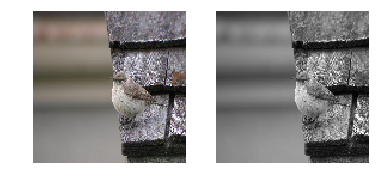

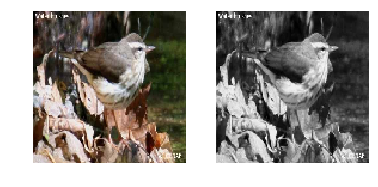

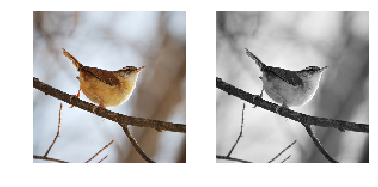

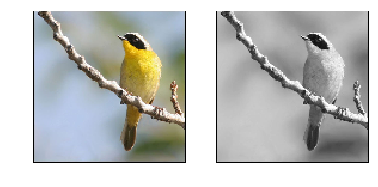

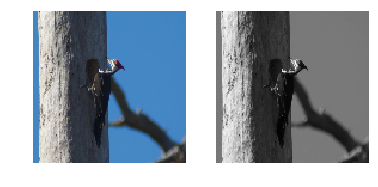

In [6]:
print(train_grays.shape, train_images.shape)
print(np.min(train_grays), np.max(train_grays), np.min(train_images), np.max(train_images))
print(test_grays.shape, test_images.shape)
print(np.min(test_grays), np.max(test_grays), np.min(test_images), np.max(test_images))

for i in range(5):
    ind = np.random.randint(len(test_images))
    plt.subplot(121)
    plt.imshow(test_images[ind])
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(test_grays[ind, :, :, 0], cmap = "gray")
    plt.axis('off')
    plt.show()

# Learning

In [7]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D
from tensorflow.python.keras.layers import Concatenate, BatchNormalization, RepeatVector, Flatten, Dense, Reshape

def midLevelFeatureNetwork():
    features = Input((w, h, 1), name = "input_features")
    
    conv00 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(features))
    conv01 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(conv00))
    meanpool0 = AveragePooling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(meanpool0))
    conv11 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(conv10))
    meanpool1 = AveragePooling2D((2, 2))(conv11)
    
    conv20 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(meanpool1))
    conv21 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(conv20))
    
    return Model(inputs = features, outputs = conv21)

def colorizationNetwork(nmeanpool = 2):
    features = Input((w // (2**nmeanpool), h // (2**nmeanpool), 256), name = "input_features")
    
    conv00 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(features))
    conv01 = BatchNormalization()(Conv2D(128, (3, 3), activation='relu', padding = "same")(conv00))
    up0 = UpSampling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(up0))
    conv11 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(conv10))
    up1 = UpSampling2D((2, 2))(conv11)
    
    conv20 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(up1))
    conv21 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(conv20))
    
    return Model(inputs = features, outputs = conv21)

def globalFeatureNetwork(nmeanpool = 2):
    w_, h_ = w // (2**nmeanpool), h // (2**nmeanpool)
    features = Input((w_, h_, 128), name = "input_features")
    
    meanpool0 = AveragePooling2D((2, 2))(features)
    
    conv00 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(meanpool0))
    conv01 = BatchNormalization()(Conv2D(32, (3, 3), activation='relu', padding = "same")(conv00))
    meanpool1 = AveragePooling2D((2, 2))(conv01)
    
    conv10 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(meanpool1))
    conv11 = BatchNormalization()(Conv2D(64, (3, 3), activation='relu', padding = "same")(conv10))
    
    flatten = Flatten()(conv11)

    dense0 = BatchNormalization()(Dense(512, activation = "relu")(flatten))
    dense1 = BatchNormalization()(Dense(256, activation = "relu")(dense0))
    dense2 = BatchNormalization()(Dense(128, activation = "relu")(dense1))
    
    output = Reshape((w_, h_, -1))(RepeatVector(w_ * h_)(dense2))
    
    return Model(inputs = features, outputs = output)

def build_model():
    
    features = Input((w, h, 1), name = "input_features")
    
    midLevelFeatures = midLevelFeatureNetwork()(features)
    
    globalFeatures = globalFeatureNetwork()(midLevelFeatures)
    
    chrominance = colorizationNetwork()(Concatenate()([midLevelFeatures, globalFeatures]))
    
    output = Conv2D(3, (3, 3), activation='sigmoid', padding = "same")(Concatenate()([chrominance, features]))
    
    model = Model(inputs = features, outputs = output)
    
    model.compile(optimizer='adadelta', loss='mean_squared_error')
    
    return model

model = build_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_features (InputLayer)     (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32, 32, 128)  288224      input_features[0][0]             
__________________________________________________________________________________________________
model_2 (Model)                 (None, 32, 32, 128)  2367808     model_1[1][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 32, 256)  0           model_1[1][0]                    
                                                                 model_2[1][0]                    
__________

In [11]:
nepochs = 10
history = model.fit(train_grays, train_images,
                    epochs=nepochs, batch_size=batch_size,
                    validation_data = (test_grays, test_images))
history_dict = history.history

Train on 10602 samples, validate on 1178 samples
Epoch 1/10
10602/10602 [==============================] - 126s 12ms/step - loss: 0.0128 - val_loss: 0.0141
Epoch 2/10
10602/10602 [==============================] - 126s 12ms/step - loss: 0.0121 - val_loss: 0.0128
Epoch 3/10
10602/10602 [==============================] - 126s 12ms/step - loss: 0.0114 - val_loss: 0.0141
Epoch 4/10
10602/10602 [==============================] - 126s 12ms/step - loss: 0.0108 - val_loss: 0.0122
Epoch 5/10
10602/10602 [==============================] - 126s 12ms/step - loss: 0.0103 - val_loss: 0.0127
Epoch 6/10
10602/10602 [==============================] - 126s 12ms/step - loss: 0.0099 - val_loss: 0.0123
Epoch 7/10
10602/10602 [==============================] - 126s 12ms/step - loss: 0.0095 - val_loss: 0.0112
Epoch 8/10
10602/10602 [==============================] - 126s 12ms/step - loss: 0.0090 - val_loss: 0.0110
Epoch 9/10
10602/10602 [==============================] - 126s 12ms/step - loss: 0.0087 - val_l

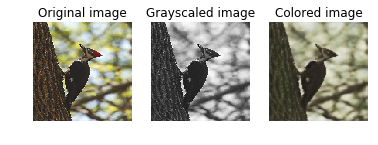

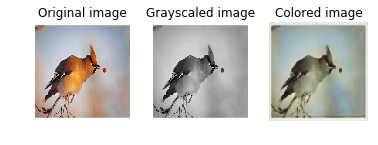

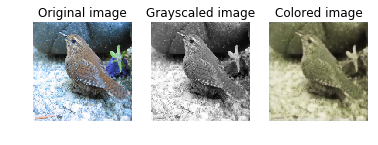

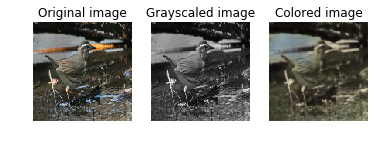

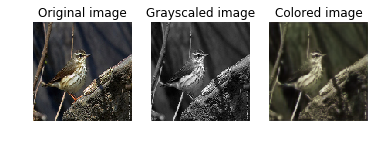

In [12]:
test_preds = model.predict(test_grays)

for i in range(5):
    ind = np.random.randint(len(test_preds))
    plt.subplot(131)
    plt.imshow(test_images[ind])
    plt.title("Original image")
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(test_grays[ind, :, :, 0], cmap = "gray")
    plt.title("Grayscaled image")
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(test_preds[ind])
    plt.title("Colored image")
    plt.axis('off')
    plt.show()

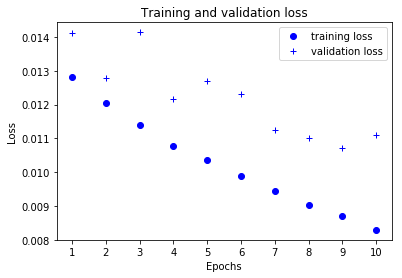

In [13]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo', label = 'training loss')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+', label = 'validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(1 + np.arange(nepochs))
plt.legend(loc = 'best')
plt.title('Training and validation loss')
plt.show()